# Modeling Heart Disease Prediction Success Rate

In this step of the Machine learning process, I will use the transformed and processed data to test how different 
ML models predict whether an individual is likely to have Heart Disease. I will use the different evaluation metrics to compare the models to find the most accurate ML model to predict Heart Disease in a person.

In [1]:
# Importing all the necessary libraries to build the ML models

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

print('done')

done


In [2]:
df = pd.read_csv('Data/Pre-Processed_data', index_col=0)
df.head()

,FastingBS,HeartDisease,Sex_F,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,RestingECG_LVH,RestingECG_Normal,ExerciseAngina_N,ST_Slope_Flat,ST_Slope_Up,scaled_Age,scaled_RestingBP,scaled_Cholesterol,scaled_MaxHR,scaled_Oldpeak
0,0,0,0,0,1,0,0,1,1,0,1,0.244898,0.500000,0.393822,0.788732,0.295455
1,0,1,1,0,0,1,0,1,1,1,0,0.428571,0.666667,0.183398,0.676056,0.409091
2,0,0,0,0,1,0,0,0,1,0,1,0.183673,0.416667,0.382239,0.267606,0.295455
3,0,1,1,1,0,0,0,1,0,1,0,0.408163,0.483333,0.249035,0.338028,0.465909
4,0,0,0,0,0,1,0,1,1,0,1,0.530612,0.583333,0.212355,0.436620,0.295455


In [176]:
# Creating X and y variables for the train test split
y = df[['HeartDisease']]
X = df.drop('HeartDisease', axis=1)
X.head()

,FastingBS,Sex_F,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,RestingECG_LVH,RestingECG_Normal,ExerciseAngina_N,ST_Slope_Flat,ST_Slope_Up,scaled_Age,scaled_RestingBP,scaled_Cholesterol,scaled_MaxHR,scaled_Oldpeak
0,0,0,0,1,0,0,1,1,0,1,0.244898,0.500000,0.393822,0.788732,0.295455
1,0,1,0,0,1,0,1,1,1,0,0.428571,0.666667,0.183398,0.676056,0.409091
2,0,0,0,1,0,0,0,1,0,1,0.183673,0.416667,0.382239,0.267606,0.295455
3,0,1,1,0,0,0,1,0,1,0,0.408163,0.483333,0.249035,0.338028,0.465909
4,0,0,0,0,1,0,1,1,0,1,0.530612,0.583333,0.212355,0.436620,0.295455


In [177]:
# Changing the shape of y to fit (n_samples,)
y = y.values.ravel()
y.shape

(917,)

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 17, test_size = 0.3)
X_train.dtypes

FastingBS               int64
Sex_F                   int64
ChestPainType_ASY       int64
ChestPainType_ATA       int64
ChestPainType_NAP       int64
RestingECG_LVH          int64
RestingECG_Normal       int64
ExerciseAngina_N        int64
ST_Slope_Flat           int64
ST_Slope_Up             int64
scaled_Age            float64
scaled_RestingBP      float64
scaled_Cholesterol    float64
scaled_MaxHR          float64
scaled_Oldpeak        float64
dtype: object

First, I will create a Dummy Classifier to see what a random model will predict regarding Heart Disease

In [202]:
strategy = ["most_frequent", "prior", "stratified", "uniform"]

for strat in strategy:
    dummy_clf = DummyClassifier(strategy=strat)
    dummy_clf.fit(X_train, y_train)
    dummy_clf.predict(X_test)
    print(strat, dummy_clf.score(X_test, y_test))

most_frequent 0.5434782608695652
prior 0.5434782608695652
stratified 0.532608695652174
uniform 0.5144927536231884


About a 50/50 split with the Dummy Classifier and now I have a comparison for all of my other models

### Logistic Regression

In [179]:
log_reg = LogisticRegression()

In [180]:
# I will be using GridSearchCV to find the best hyperparameters to predict Heart Failure for a Logistic Regression 
# model
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

In [181]:
gscv = GridSearchCV(log_reg, param_grid = param_grid, cv=3, verbose=True, n_jobs=-1)
print('Completed')

Completed


In [182]:
best_model = gscv.fit(X_train,y_train)

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/balakandikonda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/User

In [183]:
best_model.best_estimator_

LogisticRegression(C=0.08858667904100823, solver='liblinear')

The best hyper paremeters for a Logistic Regression are C=0.08858667904100823, solver='liblinear'.

In [185]:
print('The test accuracy score', best_model.score(X_test,y_test))
print('')
print('Classification Report for Test set')
print(classification_report(y_test, best_model.predict(X_test)))

The test accuracy score 0.8731884057971014

Classification Report for Test set
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       126
           1       0.86      0.91      0.89       150

    accuracy                           0.87       276
   macro avg       0.88      0.87      0.87       276
weighted avg       0.87      0.87      0.87       276



Looking at the evaluation above, we lost a small percent of accuracy from the train data and the test data but it is not statistically significant. The precision/recall/f1-score are about the same for the train and test set.

In [189]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

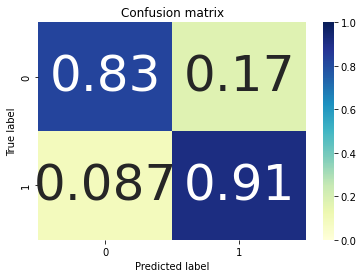

In [198]:
cm = confusion_matrix(y_test, best_model.predict(X_test))
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(cm_norm, best_model.classes_)

The confusion matrix above tells us that we accurately predicted Heart Disease 83% of the time and accurately predicted mot having Heart Failure 91% of the time. The Logistic Regression model is better at predicting whether a person has Heart Disease vs not having Heart Disease.

In [191]:
# Here I will calculate the Log Loss metric for this model
print('Log Loss from train set: ',log_loss(y_train, best_model.predict_proba(X_train)))
print('Log Loss from test set: ',log_loss(y_test, best_model.predict_proba(X_test)))

Log Loss from train set:  0.35929766043785444
Log Loss from test set:  0.35707539170077096


# Random Forest Classifier

In [194]:
rf = RandomForestClassifier(n_estimators=100, criterion = 'gini')
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [195]:
print('Training Accuracy is: ', rf.score(X_train, y_train))
print('Testing Accuracy is: ', rf.score(X_test, y_test))

Training Accuracy is:  1.0
Testing Accuracy is:  0.8478260869565217


Classification accuracy on test set with max features = 1 and max_depth = None: 0.859
Classification accuracy on test set with max features = 1 and max_depth = 2: 0.848
Classification accuracy on test set with max features = 1 and max_depth = 3: 0.848
Classification accuracy on test set with max features = 1 and max_depth = 4: 0.841
Classification accuracy on test set with max features = 1 and max_depth = 5: 0.851
Classification accuracy on test set with max features = sqrt and max_depth = None: 0.851
Classification accuracy on test set with max features = sqrt and max_depth = 2: 0.859
Classification accuracy on test set with max features = sqrt and max_depth = 3: 0.855
Classification accuracy on test set with max features = sqrt and max_depth = 4: 0.873
Classification accuracy on test set with max features = sqrt and max_depth = 5: 0.877
Classification accuracy on test set with max features = log2 and max_depth = None: 0.851
Classification accuracy on test set with max features = log2

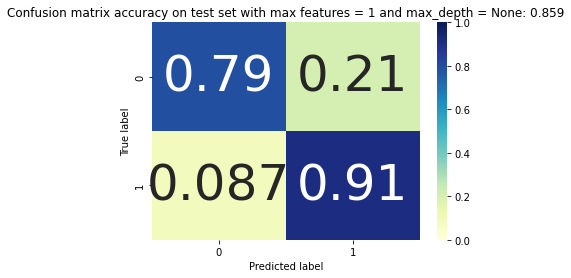

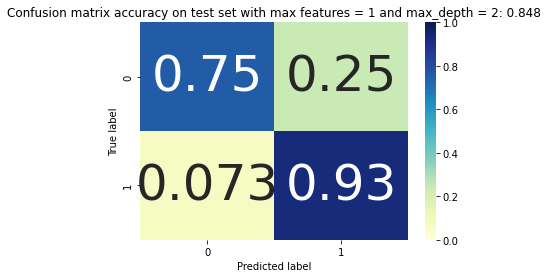

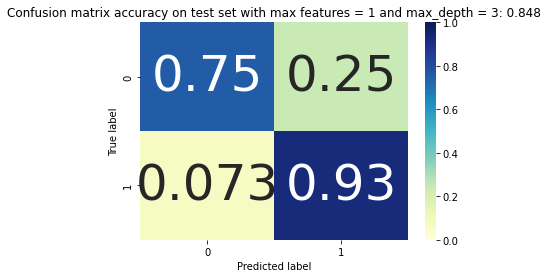

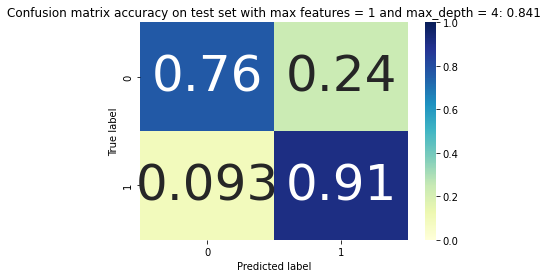

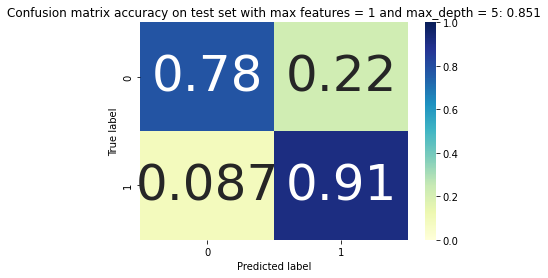

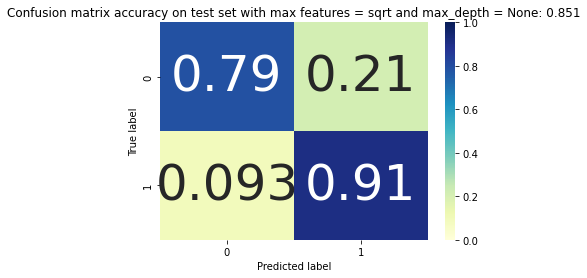

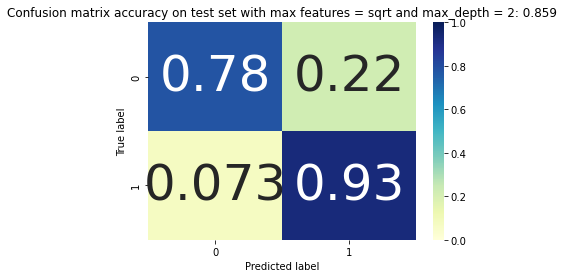

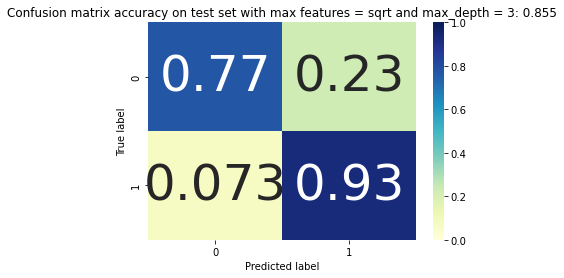

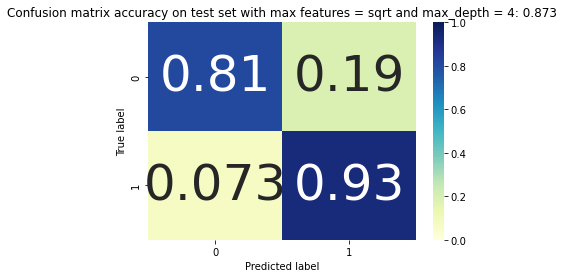

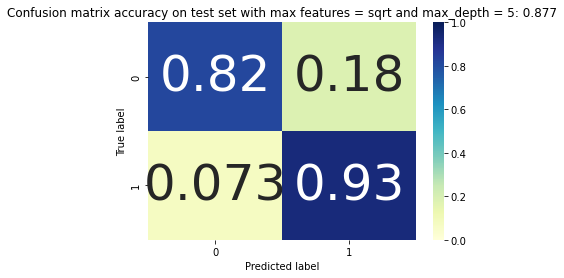

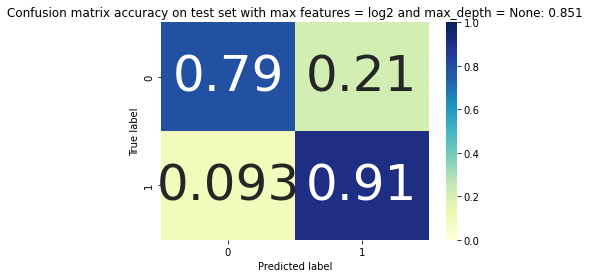

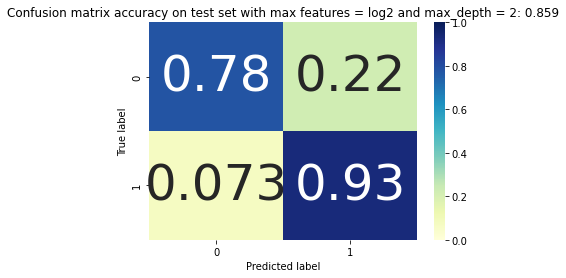

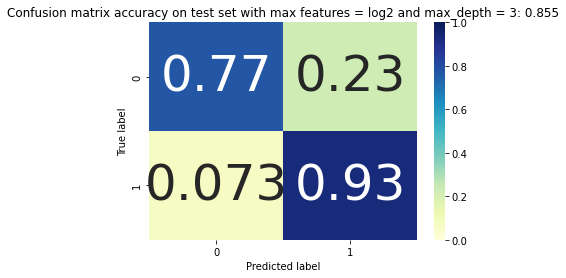

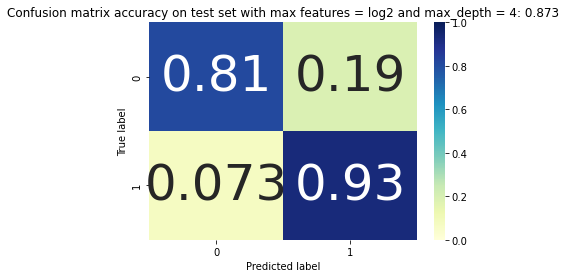

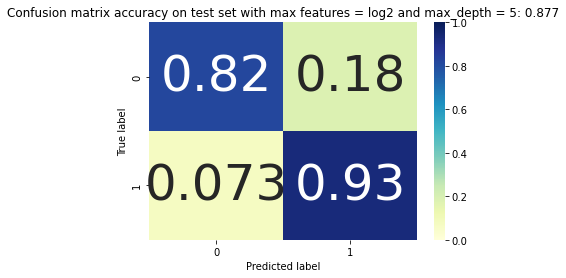

In [201]:
from itertools import product

n_estimators = 100
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 3, 4, 5]
for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='gini', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=17)
    rf.fit(X_train, y_train)
    prediction_test = rf.predict(X=X_test)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))
    
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_,
        title='Confusion matrix accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))
                          

In [221]:
rf2 = RandomForestClassifier(n_estimators=100, 
                                criterion='gini', 
                                max_features='log2', 
                                max_depth=5, 
                                n_jobs=2,
                                random_state=17)
rf2.fit(X_train, y_train)
prediction_test = rf2.predict(X=X_test)


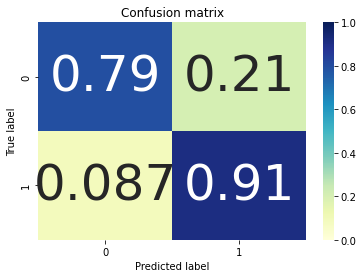

In [228]:
cm2 = confusion_matrix(y_test, rf2.predict(X_test))
cm_norm2 = cm2 / cm2.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(cm_norm2, rf2.classes_)

In [224]:
print('The test accuracy score', rf2.score(X_test,y_test))
print('')
print('Classification Report for Test set')
print(classification_report(y_test, rf2.predict(X_test)))

The test accuracy score 0.8586956521739131

Classification Report for Test set
              precision    recall  f1-score   support

           0       0.88      0.79      0.84       126
           1       0.84      0.91      0.88       150

    accuracy                           0.86       276
   macro avg       0.86      0.85      0.86       276
weighted avg       0.86      0.86      0.86       276



In [222]:
print('Log Loss from train set: ',log_loss(y_train, rf2.predict_proba(X_train)))
print('Log Loss from test set: ',log_loss(y_test, rf2.predict_proba(X_test)))

Log Loss from train set:  0.27216656373228
Log Loss from test set:  0.35495545558653957


Here, I ran the Random Forest Classifier with several different hyper parameters to find the best model. Max_depth of 5 was the best for all max_features except for max_features=1. The most accurate models were with max features as sqrt or log2 and with max depth of 5, score = 0.877.

# K Nearest Neighbor

In [207]:
knn_scores = []
for k in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=10)
    knn_scores.append(score.mean())

In [216]:
knn_scores = list(np.around(np.array(knn_scores),3))

[0.825,
 0.788,
 0.85,
 0.846,
 0.852,
 0.847,
 0.864,
 0.853,
 0.856,
 0.849,
 0.847,
 0.852,
 0.847,
 0.853,
 0.852,
 0.855,
 0.855,
 0.849,
 0.85]

Text(0.5, 1.0, 'Scores of KNN Model for different K')

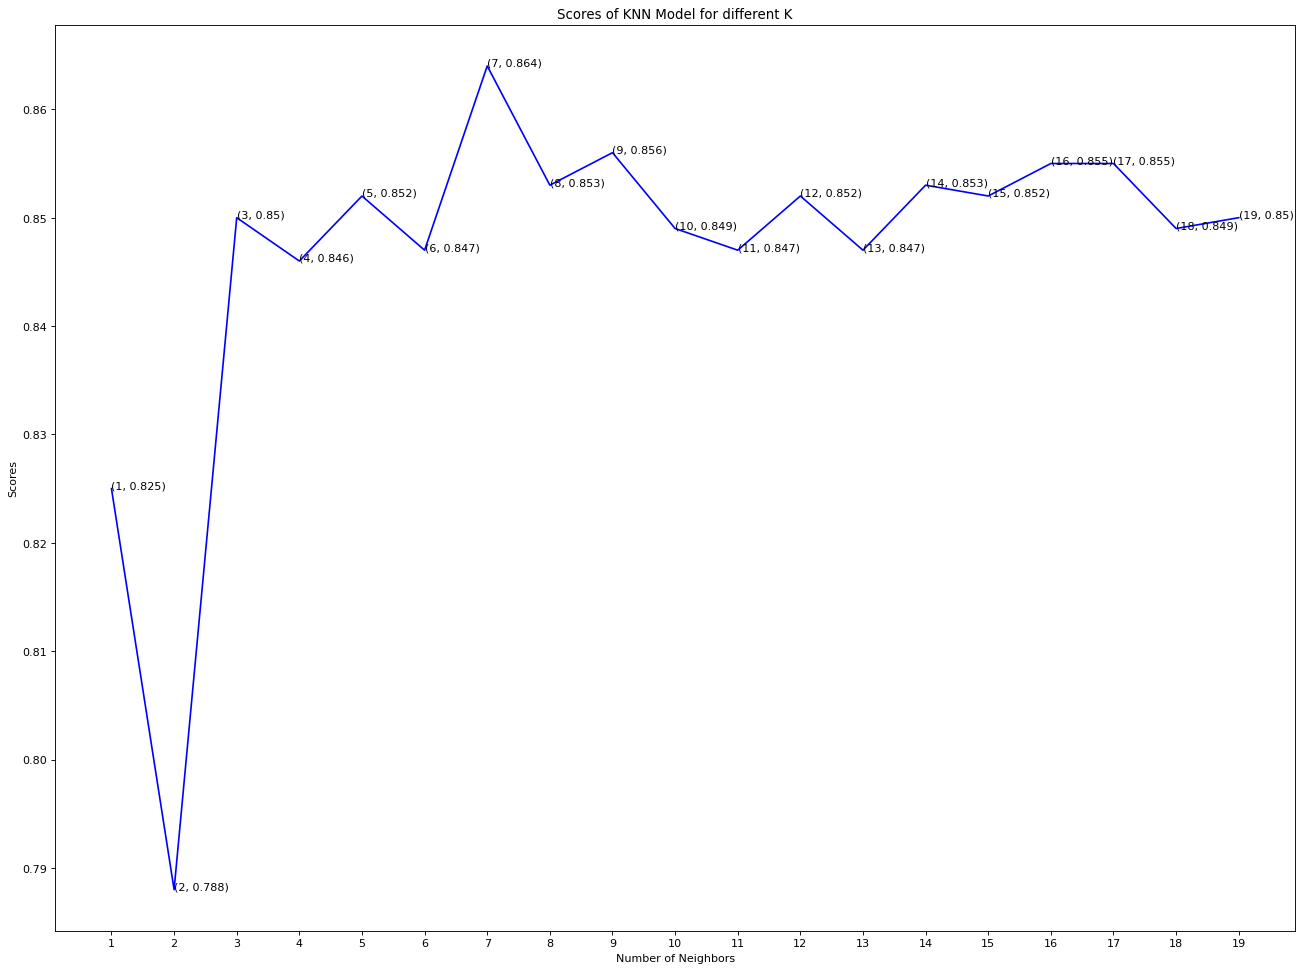

In [217]:
figure(figsize=(20, 15), dpi=80)

plt.plot([k for k in range(1,20)], knn_scores, color='blue')
for i in range(1,20):
    plt.text(i, knn_scores[i-1], (i, knn_scores[i-1]))
plt.xticks([i for i in range(1,20)])
plt.xlabel('Number of Neighbors')
plt.ylabel('Scores')
plt.title('Scores of KNN Model for different K')

The best K number if neighbors is 7 based on the chart above with an accuracy score of 0.864.

In [219]:
knn2 = KNeighborsClassifier(n_neighbors=7)
knn2.fit(X_train, y_train)
knn2.predict(X_test)

array([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0])

In [225]:
print('The test accuracy score', knn2.score(X_test,y_test))
print('')
print('Classification Report for Test set')
print(classification_report(y_test, knn2.predict(X_test)))

The test accuracy score 0.8369565217391305

Classification Report for Test set
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       126
           1       0.82      0.89      0.86       150

    accuracy                           0.84       276
   macro avg       0.84      0.83      0.83       276
weighted avg       0.84      0.84      0.84       276



In [227]:
print('Log Loss from train set: ',log_loss(y_train, knn2.predict_proba(X_train)))
print('Log Loss from test set: ',log_loss(y_test, knn2.predict_proba(X_test)))

Log Loss from train set:  0.2567398438983905
Log Loss from test set:  1.3855166196696929


Since the log loss for the test set is greater than 1, means that the predicted probability for that given class would be less than exp(-1) or around 0.368.

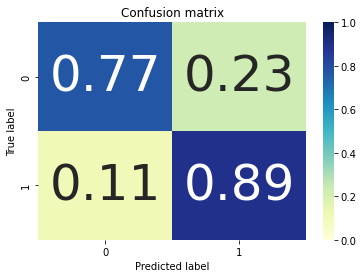

In [220]:
cm3 = confusion_matrix(y_test, knn2.predict(X_test))
cm_norm3 = cm3 / cm3.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(cm_norm3, knn2.classes_)

The KNN model correctly predicted people with Heart Disease only 77% of the time but it is not as accurate as the previous models.

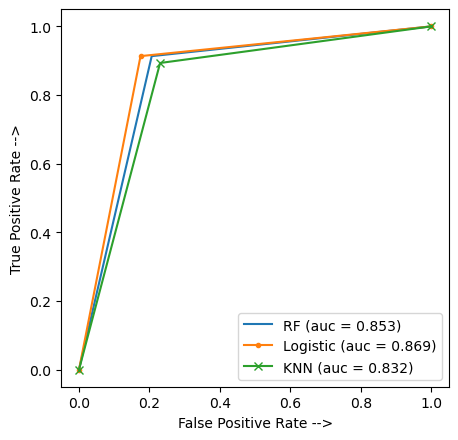

In [231]:
logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, best_model.predict(X_test))
auc_logistic = auc(logistic_fpr, logistic_tpr)

rf_fpr, rf_tpr, threshold = roc_curve(y_test, rf2.predict(X_test))
auc_rf = auc(rf_fpr, rf_tpr)

knn_fpr, knn_tpr, threshold = roc_curve(y_test, knn2.predict(X_test))
auc_knn = auc(knn_fpr, knn_tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(rf_fpr, rf_tpr, linestyle='-', label='RF (auc = %0.3f)' % auc_rf)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic (auc = %0.3f)' % auc_logistic)
plt.plot(knn_fpr, knn_tpr, marker='x', label='KNN (auc = %0.3f)' % auc_knn)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

Conclusion:

I ran 3 separate ML models to predict Heart Disease: Logistic Regression, Random Forest, and K Nearest Neighbors. Since, we are trying to predict Heart Disease, the goal is to have highest accuracy of  True Positives (top left of confusion matrix) and highest accuracy for False Negatives (bottom left of confusion matrix). This way we are accurately predicting how likely someone is to have Heart Disease and not giving any false sense of security.

Recall is the most important metrics to look at for this problem. Recall because we need to know the number of items correctly classified out of all the true positives.

Log loss is moot for all 3 models because they are all around the same number with a slight edge to the Random Forest Classifier (0.355).

The Logistic Regression model is the best ML model for this problem because it has the highest accuracy at 0.87, highest recall for predicting people with Heart Disease at 0.83, and tied for the highes recall for people without heart diseases at 0.91, along with the Random Forest model.

Taking a look at the confusion matrix for all 3, the Logistic Regression model accurately predicted someone having Heart Disease 83% of the time, while the Random Forest predicted 79% of the time, and KNN only 77% of the time.

The Logistic Regression was also tied for the best False negative rate as well (with the Random Forest model), at 0.087 while the KNN was at 0.11.

The Logistic Regression model also wins out in the ROC-AUC curve with the AUC of 0.869, slightly better than the Random Forest Classifier.

The Logistic Regression model is the best ML model for this use-case.
